In [91]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [113]:
# Get unit color distribution and ratio
def summon(desired_color, num_wanted, free_pull, in_rand_pool, start_pct, num_per_rar, ratio_in_rar):
    summon_complete = False
    num_pulled = 0
    pity_rate_count = 0
    orbs_spent = 0
    pity_breakers = 0
    while not summon_complete:
        # Generate 5 random numbers to simulate 5 stones
        pull = np.random.rand(5)
        # Get current pity rate
        pity_incr = int(pity_rate_count / 5) * .005
        # Current summon percentages
        curr_pct = ([start_pct[0] + pity_incr * start_pct[0] / (start_pct[0] + start_pct[1]),
                     start_pct[1] + pity_incr * start_pct[1] / (start_pct[0] + start_pct[1]),
                     start_pct[2] - pity_incr * start_pct[2] / (start_pct[2] + start_pct[3] + start_pct[4]),
                     start_pct[3] - pity_incr * start_pct[3] / (start_pct[2] + start_pct[3] + start_pct[4]),
                     start_pct[4] - pity_incr * start_pct[4] / (start_pct[2] + start_pct[3] + start_pct[4])])
        # Probability of drawing a specific color and rarity
        prob_of_draw = (ratio_in_rar.T * curr_pct).T
        # Probability of specific color
        color_prob = sum(prob_of_draw)
        # Probability of rarity given color
        # prob_per_color = np.true_divide(prob_of_draw, color_prob)

        # Cutoffs to determine what color and rarity is pulled
        color_cutoff = np.add.accumulate(color_prob)
        rarity_cutoff = np.concatenate((np.array([0]), color_cutoff))
        # Generate color of orbs
        stone_color = [0]*5
        stone_remainder = np.zeros(5)
        for i in range(0,5):
            stone_color[i] = np.size(color_cutoff[(color_cutoff < pull[i])])
            stone_remainder[i] = pull[i] - rarity_cutoff[stone_color[i]]
        # Number of stones present for desired color
        wanted_stones = stone_color.count(desired_color)
        if wanted_stones > 0: # Pull desired color
            cost_index = 1
            pity_broken = False
            p_5f = prob_of_draw[0][desired_color]
            p_5 = prob_of_draw[1][desired_color]
            p_4f = prob_of_draw[2][desired_color]
            p_4 = prob_of_draw[3][desired_color]
            p_3 = prob_of_draw[4][desired_color]
            # Determine what rarity/unit the stone is
            for i in range(0,5):
                c = stone_color[i]
                rem = stone_remainder[i]
                if c == desired_color:
                    if not free_pull:
                        orbs_spent += 5 - int((cost_index + 1) / 3)
                    else:
                        free_pull = False
                    pity_rate_count += 1
                    cost_index += 1
                    # Determine if pull was desired unit or pity broken
                    if rem < np.true_divide(p_5f, num_per_rar[0][c]):
                        num_pulled += 1
                        pity_broken = True
                    elif in_rand_pool[0] and rem > p_5f and rem < p_5f + np.true_divide(p_5, num_per_rar[1][c]):
                        num_pulled += 1
                        pity_broken = True
                    elif rem < p_5f+p_5:
                        pity_breakers += 1
                        pity_broken = True
                    elif num_per_rar[2][c] > 0 and rem < p_5f+p_5+np.true_divide(p_4f, num_per_rar[2][c]):
                        num_pulled += 1
                    elif (in_rand_pool[1] and rem > p_5f+p_5+p_4f and 
                          rem < p_5f+p_5+p_4f+np.true_divide(p_4, num_per_rar[3][c])):
                        num_pulled += 1
                    elif (in_rand_pool[2] and rem > p_5f+p_5+p_4f+p_4 and 
                          rem < p_5f+p_5+p_4f+p_4+np.true_divide(p_3, num_per_rar[4][c])):
                        num_pulled += 1
                if num_pulled == num_wanted:
                    summon_complete = True
                    # Completely stop summoning when desired unit pulled
                    break
            if pity_broken:
                pity_rate_count = 0
        else: # Pull optimal alternative color because desired color not present
            color_not_present = np.invert(np.in1d([0, 1, 2, 3], stone_color))
            break_prob = np.true_divide(prob_of_draw[0] + prob_of_draw[1], color_prob)
            alt_color = np.argmin(break_prob + color_not_present)
            for i in range(0,5):
                if stone_color[i] == alt_color:
                    if not free_pull:
                        orbs_spent += 5
                    else:
                        free_pull = False
                    pity_rate_count += 1
                    # Pity break if 5* summoned
                    if stone_remainder[i] < prob_of_draw[0][alt_color] + prob_of_draw[1][alt_color]:
                        pity_breakers += 1
                        pity_rate_count = 0
                    break
    return orbs_spent

In [134]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Input data
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
start_pct = np.array([0.03, 0.03, 0.00, 0.58, 0.36]) #5*f, 5*, 4*f, 4*, 3* 
random_pool = np.array([[25, 15, 11, 8],  #5* exclusive
                        [15, 15, 9, 12],  #4-5*
                        [15, 12, 9, 13]]) #3-4*
focus_5s = np.array([1, 1, 1, 1]) # R, B, G, C
focus_4s = np.array([0, 0, 0, 0])
desired_color = 0 # R=0, B=1, G=2, C=3 (replaced by color below)
free_pull = False
in_rand_pool = [True, True, False] #If in 5*, 4*, 3* pools and pulling that rarity is okay
banner = '45' #reg, hf, leg, 45
num_wanted = 1 # 1 for 5*, 11 for 5*+10 
num_trials = 100000
color = 'c' #r, b, g, c
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

if banner == 'reg':
    start_pct = np.array([0.03, 0.03, 0.00, 0.58, 0.36])
elif banner == 'hf':
    start_pct = np.array([0.05, 0.03, 0.00, 0.58, 0.34])
elif banner == 'leg':
    start_pct = np.array([0.08, 0.00, 0.00, 0.58, 0.34])
    focus_5s = np.array([3, 3, 3, 3])
elif banner == '45':
    start_pct = np.array([0.03, 0.03, 0.29, 0.29, 0.36])
    focus_5s = np.array([3, 3, 3 , 3])
    focus_4s = np.array([3, 3, 3, 3])
if color == 'r':
    desired_color = 0
elif color == 'b':
    desired_color = 1
elif color == 'g':
    desired_color = 2
elif color == 'c':
    desired_color = 3

orbs = [0] * num_trials
num_per_rar = np.vstack((focus_5s, random_pool[0,:]+random_pool[1,:], focus_4s,
                        random_pool[1,:]+random_pool[2,:], random_pool[2,:]))
ratio_in_rar = np.true_divide(num_per_rar, num_per_rar.sum(axis=1, keepdims=True), where=num_per_rar!=0)

for i in range(0,num_trials):
    orbs[i] = summon(desired_color, num_wanted, free_pull, in_rand_pool, start_pct, num_per_rar, ratio_in_rar)
    if i % 1000 == 0:
        clear_output()
        print("Trials finished: %d" % i)
print("Trials finished: %d" % num_trials)

Trials finished: 99000
Trials finished: 100000


Num. Trials: 100000
First pull: 0.088750
0-49: 0.645080
50-99: 0.241550
100-149: 0.076470
150-199: 0.024870
200-249: 0.007840
250-299: 0.002860
300-349: 0.000920
350+: 0.000410
Mean: 47.602720
Std. Dev.: 44.443349
Median: 34
90th perc.: 105
Max: 701


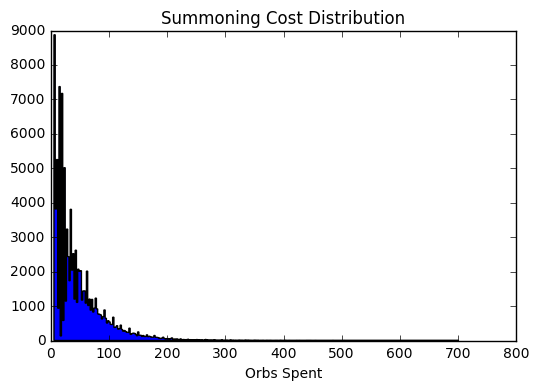

In [135]:
num_trials = float(num_trials)
np_orbs = np.array(orbs)
print("Num. Trials: %d" % num_trials)
if num_wanted > 5:
    print("0-499: %f" % (np.size(np_orbs[(np_orbs < 500)]) / num_trials))
    print("500-999: %f" % (np.size(np_orbs[(np_orbs >= 500) & (np_orbs < 1000)]) / num_trials))
    print("1000-1499: %f" % (np.size(np_orbs[(np_orbs >= 1000) & (np_orbs < 1500)]) / num_trials))
    print("1500-1999: %f" % (np.size(np_orbs[(np_orbs >= 1500) & (np_orbs < 2000)]) / num_trials))
    print("2000-2499: %f" % (np.size(np_orbs[(np_orbs >= 2000) & (np_orbs < 2500)]) / num_trials))
    print("2500-2999: %f" % (np.size(np_orbs[(np_orbs >= 2500) & (np_orbs < 3000)]) / num_trials))
    print("3000-3499: %f" % (np.size(np_orbs[(np_orbs >= 3000) & (np_orbs < 3500)]) / num_trials))
    print("3500+: %f" % (np.size(np_orbs[(np_orbs >= 3500)]) / num_trials))
else:
    print("First pull: %f" % (np.size(np_orbs[(np_orbs == 5)]) / num_trials))
    print("0-49: %f" % (np.size(np_orbs[(np_orbs < 50)]) / num_trials))
    print("50-99: %f" % (np.size(np_orbs[(np_orbs >= 50) & (np_orbs < 100)]) / num_trials))
    print("100-149: %f" % (np.size(np_orbs[(np_orbs >= 100) & (np_orbs < 150)]) / num_trials))
    print("150-199: %f" % (np.size(np_orbs[(np_orbs >= 150) & (np_orbs < 200)]) / num_trials))
    print("200-249: %f" % (np.size(np_orbs[(np_orbs >= 200) & (np_orbs < 250)]) / num_trials))
    print("250-299: %f" % (np.size(np_orbs[(np_orbs >= 250) & (np_orbs < 300)]) / num_trials))
    print("300-349: %f" % (np.size(np_orbs[(np_orbs >= 300) & (np_orbs < 350)]) / num_trials))
    print("350+: %f" % (np.size(np_orbs[(np_orbs >= 350)]) / num_trials))
print("Mean: %f" % (np.mean(np_orbs)))
print("Std. Dev.: %f" % (np.std(np_orbs)))
print("Median: %d" % (np.median(np_orbs)))
print("90th perc.: %d" % (np.percentile(np_orbs, 90)))
print("Max: %d" % (np.max(np_orbs)))

plt.hist(np_orbs, bins='auto', histtype='stepfilled')
plt.title('Summoning Cost Distribution')
plt.xlabel('Orbs Spent')

plt.show()